In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from pathlib import Path
from datetime import date, timedelta
import re
import multiprocessing as mult
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
tester = pd.read_csv('../scraping_raw/203.csv')

## Extracting games

First we will process a random batch, we will use the regular expression package to extract the games from the tweets.

In [27]:
tester['processed_text'] = tester['Text'].apply(lambda x: re.findall("[⬛🟨🟩⬜]{5}", x))

In [28]:
tester.head()

,Unnamed: 0,Game,Trial,Datetime,Tweet Id,Text,Username,URL,processed_text,proc_length
0,0,203,1,2022-01-08 23:53:02+00:00,1479964391839834119,Wordle 203 1/6\n\n🟩🟩🟩🟩🟩,danielebel,https://twitter.com/danielebel/status/14799643...,[🟩🟩🟩🟩🟩],1
1,1,203,1,2022-01-08 23:49:28+00:00,1479963495806427136,Wordle 203 1/6\n\n🟩🟩🟩🟩🟩\n\nRandomly guessing a...,glamdring1999,https://twitter.com/glamdring1999/status/14799...,[🟩🟩🟩🟩🟩],1
2,2,203,1,2022-01-08 23:29:51+00:00,1479958559467126784,First time Wordling.\nTime to quit.\n\nWordle ...,Axialmatt,https://twitter.com/Axialmatt/status/147995855...,[🟩🟩🟩🟩🟩],1
3,3,203,1,2022-01-08 23:24:13+00:00,1479957142337585154,Wordle 203 1/6\n\n🟩🟩🟩🟩🟩 \n\n🤷‍♂️🤷‍♂️🤷‍♂️🤷‍♂️🤷‍♂️,_yaowu_,https://twitter.com/_yaowu_/status/14799571423...,[🟩🟩🟩🟩🟩],1
4,4,203,1,2022-01-08 23:17:06+00:00,1479955350111596545,Wordle 203 1/6\n\n🟩🟩🟩🟩🟩,sagitariusslut,https://twitter.com/sagitariusslut/status/1479...,[🟩🟩🟩🟩🟩],1


Now we will create a column called which will contain the number of trials for each extracted game.
We will also change the trial column in order to change the 'X' position to the number 6.

In [29]:
tester['proc_length'] = tester['processed_text'].str.len()

In [30]:
tester['Trial'] = tester['Trial'].apply(lambda x: 6 if x == 'X' else int(x))

##  Premilinar data cleaning

Now we will discard any entries where the number of attemps in the header does not correspond to the number of extracted trials.

In [32]:
tester = tester.loc[tester['proc_length'] == tester['Trial']]
tester.head()

,Unnamed: 0,Game,Trial,Datetime,Tweet Id,Text,Username,URL,processed_text,proc_length
0,0,203,1,2022-01-08 23:53:02+00:00,1479964391839834119,Wordle 203 1/6\n\n🟩🟩🟩🟩🟩,danielebel,https://twitter.com/danielebel/status/14799643...,[🟩🟩🟩🟩🟩],1
1,1,203,1,2022-01-08 23:49:28+00:00,1479963495806427136,Wordle 203 1/6\n\n🟩🟩🟩🟩🟩\n\nRandomly guessing a...,glamdring1999,https://twitter.com/glamdring1999/status/14799...,[🟩🟩🟩🟩🟩],1
2,2,203,1,2022-01-08 23:29:51+00:00,1479958559467126784,First time Wordling.\nTime to quit.\n\nWordle ...,Axialmatt,https://twitter.com/Axialmatt/status/147995855...,[🟩🟩🟩🟩🟩],1
3,3,203,1,2022-01-08 23:24:13+00:00,1479957142337585154,Wordle 203 1/6\n\n🟩🟩🟩🟩🟩 \n\n🤷‍♂️🤷‍♂️🤷‍♂️🤷‍♂️🤷‍♂️,_yaowu_,https://twitter.com/_yaowu_/status/14799571423...,[🟩🟩🟩🟩🟩],1
4,4,203,1,2022-01-08 23:17:06+00:00,1479955350111596545,Wordle 203 1/6\n\n🟩🟩🟩🟩🟩,sagitariusslut,https://twitter.com/sagitariusslut/status/1479...,[🟩🟩🟩🟩🟩],1


Now we will check if any games of less than six trials don't end in a victory.

In [35]:
len(tester)

25020

In [34]:
len(tester.loc[(tester['processed_text'].str[-1] == "🟩🟩🟩🟩🟩") & tester['Trial'] < 6])

25020

Even though in this case we were lucky, we will still write the lines of code to discard the wrong entries just to have it in general case.

In [40]:
valid_games = tester.loc[(tester['processed_text'].str[-1] == "🟩🟩🟩🟩🟩") & tester['Trial'] < 6]
six_trials = tester.loc[tester['Trial'] == 6]
tester = pd.concat([valid_games, six_trials])

## Processing all batches

Now we will start processing each dataset that we have extracted in the previous notebook using the commands used in the first part of this file.

In [2]:
data = pd.DataFrame()
for i in range(196, 516):
    print("Processing batch: " + str(i))
    game = pd.read_csv('../scraping_raw/' + str(i) + '.csv')
    game['processed_text'] = game['Text'].apply(lambda x: re.findall("[⬛🟨🟩⬜]{5}", x))
    game['proc_length'] = game['processed_text'].str.len()
    game['Trial'] = game['Trial'].apply(lambda x: 6 if x == 'X' else int(x))
    game = game.loc[game['proc_length'] == game['Trial']]
    valid_games = game.loc[(game['processed_text'].str[-1] == "🟩🟩🟩🟩🟩") & game['Trial'] < 6]
    six_trials = game.loc[game['Trial'] == 6]
    game = pd.concat([valid_games, six_trials])
    data = pd.concat([data, game])
    print("Completed "+str(i))

Processing batch: 196
Completed 196
Processing batch: 197
Completed 197
Processing batch: 198
Completed 198
Processing batch: 199
Completed 199
Processing batch: 200
Completed 200
Processing batch: 201
Completed 201
Processing batch: 202
Completed 202
Processing batch: 203
Completed 203
Processing batch: 204
Completed 204
Processing batch: 205
Completed 205
Processing batch: 206
Completed 206
Processing batch: 207
Completed 207
Processing batch: 208
Completed 208
Processing batch: 209
Completed 209
Processing batch: 210
Completed 210
Processing batch: 211
Completed 211
Processing batch: 212
Completed 212
Processing batch: 213
Completed 213
Processing batch: 214
Completed 214
Processing batch: 215
Completed 215
Processing batch: 216
Completed 216
Processing batch: 217
Completed 217
Processing batch: 218
Completed 218
Processing batch: 219
Completed 219
Processing batch: 220
Completed 220
Processing batch: 221
Completed 221
Processing batch: 222
Completed 222
Processing batch: 223
Comple

Completed 423
Processing batch: 424
Completed 424
Processing batch: 425
Completed 425
Processing batch: 426
Completed 426
Processing batch: 427
Completed 427
Processing batch: 428
Completed 428
Processing batch: 429
Completed 429
Processing batch: 430
Completed 430
Processing batch: 431
Completed 431
Processing batch: 432
Completed 432
Processing batch: 433
Completed 433
Processing batch: 434
Completed 434
Processing batch: 435
Completed 435
Processing batch: 436
Completed 436
Processing batch: 437
Completed 437
Processing batch: 438
Completed 438
Processing batch: 439
Completed 439
Processing batch: 440
Completed 440
Processing batch: 441
Completed 441
Processing batch: 442
Completed 442
Processing batch: 443
Completed 443
Processing batch: 444
Completed 444
Processing batch: 445
Completed 445
Processing batch: 446
Completed 446
Processing batch: 447
Completed 447
Processing batch: 448
Completed 448
Processing batch: 449
Completed 449
Processing batch: 450
Completed 450
Processing bat

In [3]:
data.head()

,Unnamed: 0,Game,Trial,Datetime,Tweet Id,Text,Username,URL,processed_text,proc_length
0,0,196,1,2022-01-01 23:49:38+00:00,1477426821763268611,This is becoming tiresome: Wordle 196 1/6\n\n🟩...,adamhorsfall,https://twitter.com/adamhorsfall/status/147742...,[🟩🟩🟩🟩🟩],1
1,1,196,1,2022-01-01 23:33:35+00:00,1477422784217112578,Wordle 196 1/6\n\n🟩🟩🟩🟩🟩,TheRealPembo,https://twitter.com/TheRealPembo/status/147742...,[🟩🟩🟩🟩🟩],1
2,2,196,1,2022-01-01 20:25:45+00:00,1477375513580621825,"Saw a not-cryptic-enough spoiler, unfortunatel...",grenow,https://twitter.com/grenow/status/147737551358...,[🟩🟩🟩🟩🟩],1
3,3,196,1,2022-01-01 20:18:26+00:00,1477373674034327554,This is a goid start to 2022\n\nWordle 196 1/6...,Yummhh__,https://twitter.com/Yummhh__/status/1477373674...,[🟩🟩🟩🟩🟩],1
4,4,196,1,2022-01-01 19:15:18+00:00,1477357786061099011,Wordle 196 1/6\n\n🟩🟩🟩🟩🟩,TowerGuardGames,https://twitter.com/TowerGuardGames/status/147...,[🟩🟩🟩🟩🟩],1


Now we will drop some unnceseary columns.

In [4]:
data = data.drop(['proc_length', 'Tweet Id', 'URL', 'Unnamed: 0', 'Text', 'Datetime'], axis = 1)

Now we will change all of the ⬛ characters into ⬜:

In [5]:
data['processed_text'] = data['processed_text'].apply(lambda x : [word.replace('⬛', '⬜') for word in x])

In [6]:
data.head()

,Game,Trial,Username,processed_text
0,196,1,adamhorsfall,[🟩🟩🟩🟩🟩]
1,196,1,TheRealPembo,[🟩🟩🟩🟩🟩]
2,196,1,grenow,[🟩🟩🟩🟩🟩]
3,196,1,Yummhh__,[🟩🟩🟩🟩🟩]
4,196,1,TowerGuardGames,[🟩🟩🟩🟩🟩]


Now we will save the processed data:

In [7]:
data = data.reset_index()
data.to_feather('data_proc_ver_1.feather')

## Secondary cleaning

Now we will create a function that will return all the possible combinations of colors that can be generated given a target word. In order to do we will split it into smaller functions.

In [2]:
data = pd.read_feather('data_proc_ver_1.feather')

In [3]:
def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

In [4]:
def check_words(input_word ,target):
    input_word = input_word.lower()
    target = target.lower()
    sequence = ['⬜']*5
    selected = [False]*5
    for i in range(0,5):
        if input_word[i] == target[i]:
            sequence[i] = '🟩'
            selected[i] = True
    for i in range(0,5):
        if input_word[i] != target[i]:
            indexes = find(target, input_word[i])
            for index in indexes:
                if not selected[index]:
                    selected[index] = True
                    sequence[i] = '🟨'
                    break
    aux = ""
    return aux.join(sequence)

Now we will check the function in order to see if it works as inteded.

In [5]:
words = ['algae', 'keeps', 'orbit', 'abate', 'abbey']
for word in words:
    print(check_words(word, 'abbey'))

🟩⬜⬜⬜🟨
⬜🟨⬜⬜⬜
⬜⬜🟩⬜⬜
🟩🟩⬜⬜🟨
🟩🟩🟩🟩🟩


Now we will create the function that returns the set of all posible combinations given a word.

In [6]:
def set_of_words(possible_inputs, target):
    result = set()
    for word in possible_inputs:
        result.add(check_words(word, target))
    return result

In [7]:
set_of_words(words, 'abbey')

{'⬜⬜🟩⬜⬜', '⬜🟨⬜⬜⬜', '🟩⬜⬜⬜🟨', '🟩🟩⬜⬜🟨', '🟩🟩🟩🟩🟩'}

### Creating the allowed words set

Now that we have created the functions needed to pass the second cleaning, we will now compute the set of all the valid words that can be used as inputs in Wordle (from an .txt file in the repository) and also a dictionary that will link the game number with the game's target word.

In [8]:
#set of valid words
valid_inputs = []
with open("valid-wordle-words.txt") as f:
    valid_inputs = f.read().splitlines()

In [9]:
#dictionary of games and target words
game_dict = {}
with open("wordle-words-by-day.txt") as f:
    for line in f:
        line = line.strip()
        game_dict.update({int(line[0:3]) : line[4::]})

#### Adding the target word of the day
Now we will add an extra column which will be the target word associated with the game number.

In [10]:
data['target'] = data['Game'].apply(lambda x: game_dict[x])

In [11]:
data

,index,Game,Trial,Username,processed_text,target
0,0,196,1,adamhorsfall,[🟩🟩🟩🟩🟩],REBUS
1,1,196,1,TheRealPembo,[🟩🟩🟩🟩🟩],REBUS
2,2,196,1,grenow,[🟩🟩🟩🟩🟩],REBUS
3,3,196,1,Yummhh__,[🟩🟩🟩🟩🟩],REBUS
4,4,196,1,TowerGuardGames,[🟩🟩🟩🟩🟩],REBUS
...,...,...,...,...,...,...
8447871,19156,515,6,moona_moony_,"[🟨⬜⬜⬜🟨, ⬜🟨🟨⬜⬜, ⬜⬜🟨🟨🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]",BAKER
8447872,19157,515,6,JonMDexter,"[⬜⬜⬜⬜🟩, ⬜⬜⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩🟩🟩🟩, ⬜🟩🟩🟩🟩]",BAKER
8447873,19158,515,6,KuronaNuva,"[⬜🟨🟨⬜🟨, 🟨🟩🟨⬜⬜, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]",BAKER
8447874,19159,515,6,KZYONE,"[🟨🟨🟨⬜⬜, ⬜🟨🟨🟨⬜, ⬜⬜🟨🟨🟨, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]",BAKER


### Generating the a set of all posible outcomes for each target

Now we will create a dictionary which will have the game number as keys and each entry will contain the set of all posible outcomes that can be generated.


In [12]:
posible_games = {}
for i in range(196, 516):
    posible_games.update({i:set_of_words(valid_inputs, game_dict[i])})

### Finding the games with imposible combinations

Now we will find the games that contain an entry that could not have been generated by the target word

In [13]:
def checker(texts, game):
    return all([word in posible_games[game] for word in texts])

In [14]:
data['valid_game'] = data[['processed_text', 'Game']].apply(lambda x: checker(x.processed_text, x.Game), axis=1)

In [15]:
wrong = data.loc[data['valid_game'] == False]
wrong

,index,Game,Trial,Username,processed_text,target,valid_game
5031,5133,196,5,2BLuis1,"[⬜⬜🟨🟨⬜, 🟩🟩⬜⬜⬜, 🟩🟩⬜⬜⬜, 🟩🟩🟩🟨🟨, 🟩🟩🟩🟩🟩]",REBUS,False
15186,4371,197,3,SittingByTheSea,"[🟨🟨⬜⬜🟨, 🟨⬜🟩🟨🟨, 🟩🟩🟩🟩🟩]",BOOST,False
22193,11506,197,5,Battysgambit,"[⬜⬜🟨🟨⬜, 🟨⬜🟨⬜🟨, 🟩⬜⬜🟨🟩, 🟩🟨⬜🟨🟩, 🟩🟩🟩🟩🟩]",BOOST,False
22939,12257,197,5,nuclearobelisk,"[⬜🟩⬜🟩🟨, ⬜🟩⬜🟩🟨, ⬜⬜⬜⬜⬜, 🟩🟨⬜🟩⬜, 🟩🟨⬜🟨🟨]",BOOST,False
28027,2735,198,3,_Anna_Weigandt_,"[🟨🟨🟨🟨⬜, 🟩🟨🟩⬜🟩, 🟩🟩🟩🟩🟩]",TRUSS,False
...,...,...,...,...,...,...,...
8447207,18473,515,6,fer4lfrog,"[🟨⬜⬜🟨⬜, 🟨⬜⬜⬜🟨, 🟨🟨🟨⬜🟩, ⬜🟨🟨🟩🟩, 🟩🟩⬜🟩🟩, 🟩🟩⬜🟩🟩]",BAKER,False
8447377,18648,515,6,Monshi41,"[⬜⬜🟨🟨⬜, 🟨🟨⬜⬜⬜, ⬜⬜⬜🟨🟨, ⬜🟨⬜⬜🟩, ⬜🟩🟩⬜🟩, 🟩🟩🟩⬜🟩]",BAKER,False
8447468,18741,515,6,Watching_One,"[⬜⬜⬜🟨⬜, ⬜⬜🟩🟨⬜, ⬜🟩🟩⬜🟩, ⬜🟩🟩⬜🟩, 🟩⬜🟩⬜🟩, 🟩🟩🟩⬜🟩]",BAKER,False
8447594,18873,515,6,Louise_Bullock_,"[⬜⬜⬜⬜🟨, ⬜🟨🟨🟨⬜, 🟨🟨🟨⬜⬜, 🟨🟨🟨⬜⬜, ⬜🟨🟨🟨🟨, 🟨🟩🟨🟩⬜]",BAKER,False


Now we will take a look to the distribution just in case we might have an invalid input in the dictionary.

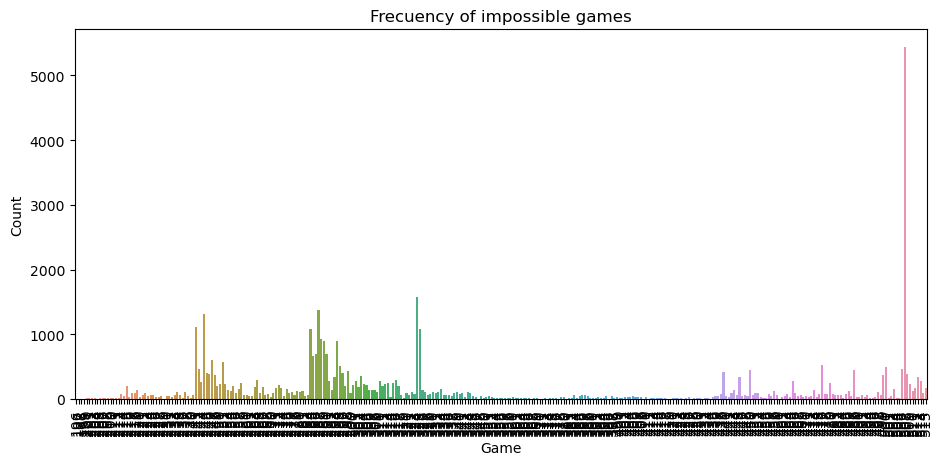

In [16]:
word_plot = sns.countplot(data = wrong, x = 'Game')
word_plot.set_xlabel("Game")
word_plot.set_ylabel("Count")
word_plot.set_title("Frecuency of impossible games")
word_plot.set_xticklabels(labels = word_plot.get_xticklabels() ,rotation = 90)
word_plot.figure.set_figwidth(11);

There's something unusual in a word, let's take a look:

In [17]:
wrong_count = wrong.groupby(by = ['Game'])['Game'].count()
wrong_count

Game
196      1
197      3
198      1
199      8
200     11
      ... 
511    179
512    337
513    281
514     93
515    171
Name: Game, Length: 320, dtype: int64

In [18]:
wrong_count.idxmax()

507

We can see that the peak appears at game 507, let's see what's happening.

In [22]:
outlier = wrong.loc[wrong['Game'] == 507]
outlier

,index,Game,Trial,Username,processed_text,target,valid_game
8270973,54,507,2,jeanne_blue,"[🟩🟩🟨⬜⬜, 🟩🟩🟩🟩🟩]",SNARL,False
8270975,56,507,2,samonoise,"[🟩⬜🟩🟩🟩, 🟩🟩🟩🟩🟩]",SNARL,False
8270984,65,507,2,M_A_M_0_5,"[🟩🟩⬜🟨🟩, 🟩🟩🟩🟩🟩]",SNARL,False
8270990,72,507,2,baikap,"[🟨⬜🟨🟩🟨, 🟩🟩🟩🟩🟩]",SNARL,False
8271008,91,507,2,GusYorkshire,"[🟩⬜🟩🟩🟩, 🟩🟩🟩🟩🟩]",SNARL,False
...,...,...,...,...,...,...,...
8290068,17643,507,6,detatan1q,"[🟨⬜⬜⬜⬜, ⬜🟨⬜⬜⬜, ⬜⬜🟨🟨⬜, 🟩🟨🟨🟩⬜, 🟩🟨🟩⬜🟨, 🟩🟩🟩⬜⬜]",SNARL,False
8290070,17645,507,6,TheLUPOL,"[⬜⬜⬜⬜🟨, 🟩🟨⬜⬜🟨, 🟩⬜🟩⬜🟩, 🟩⬜🟩🟩🟩, 🟩⬜🟩🟩🟩, 🟩⬜🟩🟩🟩]",SNARL,False
8290071,17646,507,6,DiB164,"[⬜⬜⬜🟨🟨, ⬜⬜⬜⬜⬜, 🟩🟨⬜⬜⬜, 🟩⬜🟩⬜🟩, 🟩⬜🟩🟩🟩, 🟩⬜🟩🟩🟩]",SNARL,False
8290072,17647,507,6,echi_go_ya,"[⬜⬜⬜⬜⬜, ⬜⬜🟩⬜⬜, ⬜🟨🟩⬜⬜, ⬜⬜🟩🟨⬜, 🟨🟨🟩⬜🟨, 🟩🟨🟩⬜🟨]",SNARL,False


In [24]:
outlier.describe()

,index,Game,Trial
count,5438.000000,5438.0,5438.000000
mean,11898.366679,507.0,4.815925
std,4945.491613,0.0,1.099161
min,54.000000,507.0,2.000000
25%,8294.500000,507.0,4.000000
50%,13187.500000,507.0,5.000000
75%,16244.250000,507.0,6.000000
max,17653.000000,507.0,6.000000


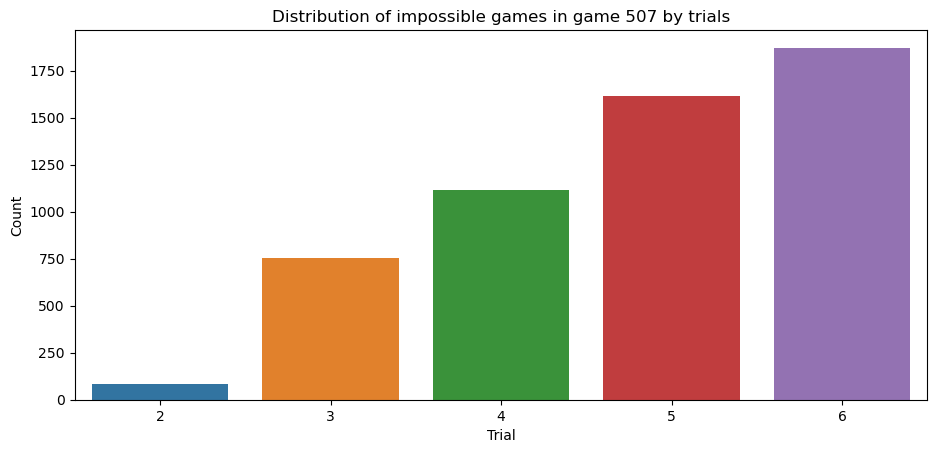

In [26]:
word_plot = sns.countplot(data = outlier, x = 'Trial')
word_plot.set_xlabel("Trial")
word_plot.set_ylabel("Count")
word_plot.set_title("Distribution of impossible games in game 507 by trials")
word_plot.figure.set_figwidth(11);

Seem a bit weird that the bulk of made up games are the ones that ended up loosing.
Since the number of invalid games is not significant, we will remove them from our dataset and perform our analysis with the remaining data.

In [27]:
data = data.loc[data['valid_game'] == True]

,index,Game,Trial,Username,processed_text,target,valid_game
0,0,196,1,adamhorsfall,[🟩🟩🟩🟩🟩],REBUS,True
1,1,196,1,TheRealPembo,[🟩🟩🟩🟩🟩],REBUS,True
2,2,196,1,grenow,[🟩🟩🟩🟩🟩],REBUS,True
3,3,196,1,Yummhh__,[🟩🟩🟩🟩🟩],REBUS,True
4,4,196,1,TowerGuardGames,[🟩🟩🟩🟩🟩],REBUS,True
...,...,...,...,...,...,...,...
8447871,19156,515,6,moona_moony_,"[🟨⬜⬜⬜🟨, ⬜🟨🟨⬜⬜, ⬜⬜🟨🟨🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]",BAKER,True
8447872,19157,515,6,JonMDexter,"[⬜⬜⬜⬜🟩, ⬜⬜⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩🟩🟩🟩, ⬜🟩🟩🟩🟩]",BAKER,True
8447873,19158,515,6,KuronaNuva,"[⬜🟨🟨⬜🟨, 🟨🟩🟨⬜⬜, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]",BAKER,True
8447874,19159,515,6,KZYONE,"[🟨🟨🟨⬜⬜, ⬜🟨🟨🟨⬜, ⬜⬜🟨🟨🟨, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩, ⬜🟩⬜🟩🟩]",BAKER,True


In [29]:
data = data.drop(['valid_game'], axis = 1)

In [32]:
data = data.reset_index()
data.to_feather('data_proc_ver_2.feather')